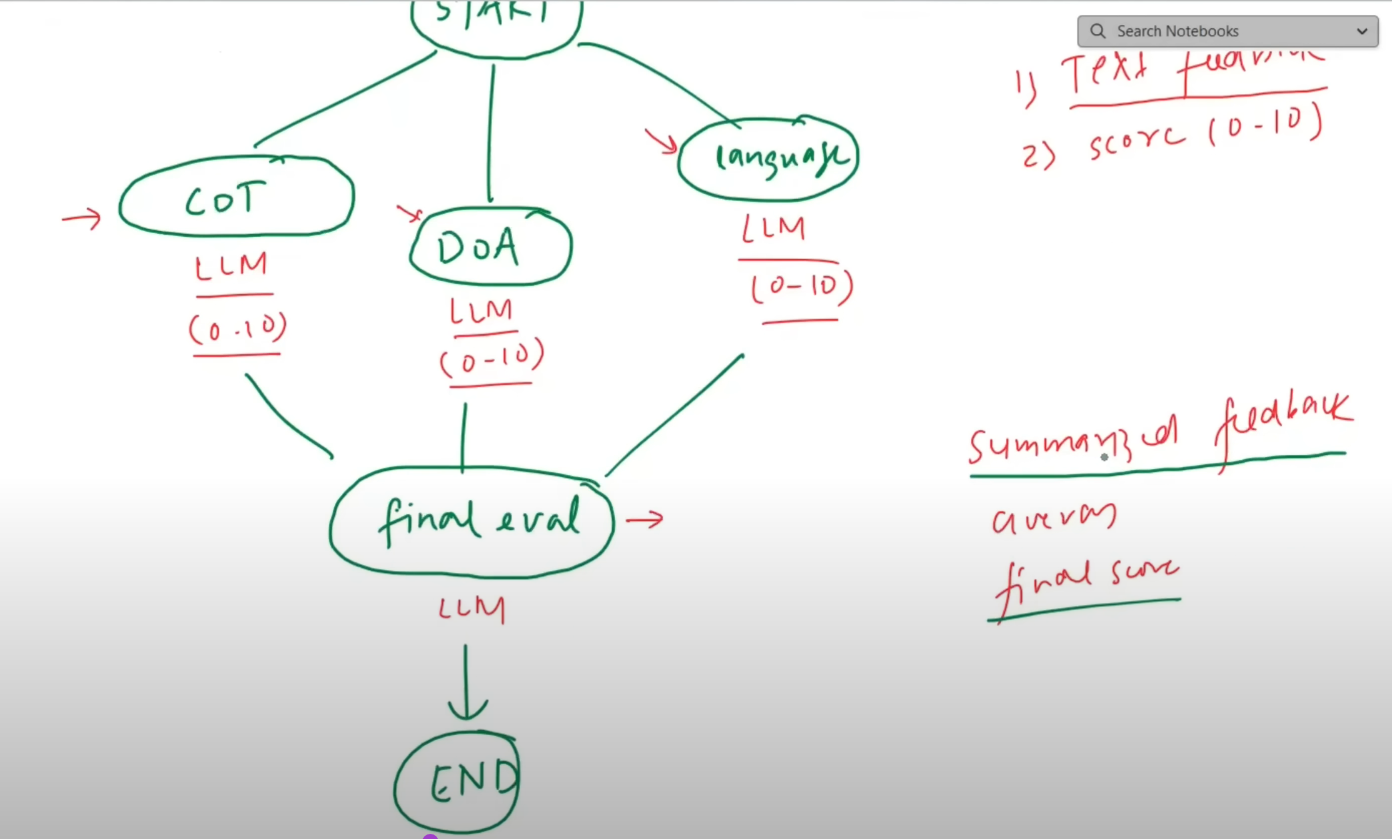


Some things which we need to make sure

1. The structure of Output for each node(Output should be json with text and score)
2. Reducer Function to use and handle attributes

```py
states = {
essay_text,
scores,
feedbacks of all three nodes
final feedback
final score
average score
}
```


- For final score we need to merge all three scores (Merging using Reducer)
- We need to make sure the output should be structured
- Handle the Paralle Workflow


In [1]:
from langchain_groq import ChatGroq
from dotenv import load_dotenv
from langgraph.graph import StateGraph, START, END
from pydantic import BaseModel, Field
from typing import TypedDict

In [2]:
load_dotenv()

True

In [15]:
model = ChatGroq(model="openai/gpt-oss-20b")

In [16]:
# We need to create a OutPut Parser and Each Output should be same.


class OutputSchema(BaseModel):
    feedback: str = Field(description="Detailed feedback for the essay")
    score: int = Field(description="Score Out of 10", ge=0, le=10)

In [17]:
model_with_structure = model.with_structured_output(OutputSchema)

In [18]:
# Test
sample_essay = """India in the Age of AI
As the world enters a transformative era defined by artificial intelligence (AI), India stands at a critical juncture — one where it can either emerge as a global leader in AI innovation or risk falling behind in the technology race. The age of AI brings with it immense promise as well as unprecedented challenges, and how India navigates this landscape will shape its socio-economic and geopolitical future.

India's strengths in the AI domain are rooted in its vast pool of skilled engineers, a thriving IT industry, and a growing startup ecosystem. With over 5 million STEM graduates annually and a burgeoning base of AI researchers, India possesses the intellectual capital required to build cutting-edge AI systems. Institutions like IITs, IIITs, and IISc have begun fostering AI research, while private players such as TCS, Infosys, and Wipro are integrating AI into their global services. In 2020, the government launched the National AI Strategy (AI for All) with a focus on inclusive growth, aiming to leverage AI in healthcare, agriculture, education, and smart mobility.

One of the most promising applications of AI in India lies in agriculture, where predictive analytics can guide farmers on optimal sowing times, weather forecasts, and pest control. In healthcare, AI-powered diagnostics can help address India’s doctor-patient ratio crisis, particularly in rural areas. Educational platforms are increasingly using AI to personalize learning paths, while smart governance tools are helping improve public service delivery and fraud detection.

However, the path to AI-led growth is riddled with challenges. Chief among them is the digital divide. While metropolitan cities may embrace AI-driven solutions, rural India continues to struggle with basic internet access and digital literacy. The risk of job displacement due to automation also looms large, especially for low-skilled workers. Without effective skilling and re-skilling programs, AI could exacerbate existing socio-economic inequalities.

Another pressing concern is data privacy and ethics. As AI systems rely heavily on vast datasets, ensuring that personal data is used transparently and responsibly becomes vital. India is still shaping its data protection laws, and in the absence of a strong regulatory framework, AI systems may risk misuse or bias.

To harness AI responsibly, India must adopt a multi-stakeholder approach involving the government, academia, industry, and civil society. Policies should promote open datasets, encourage responsible innovation, and ensure ethical AI practices. There is also a need for international collaboration, particularly with countries leading in AI research, to gain strategic advantage and ensure interoperability in global systems.

India’s demographic dividend, when paired with responsible AI adoption, can unlock massive economic growth, improve governance, and uplift marginalized communities. But this vision will only materialize if AI is seen not merely as a tool for automation, but as an enabler of human-centered development.

In conclusion, India in the age of AI is a story in the making — one of opportunity, responsibility, and transformation. The decisions we make today will not just determine India’s AI trajectory, but also its future as an inclusive, equitable, and innovation-driven society."""


In [19]:
prompt = f"Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10.\n\n{sample_essay}"

In [21]:
result = model_with_structure.invoke(prompt)

In [22]:
result

OutputSchema(feedback='The essay demonstrates a clear, organized structure with an engaging opening that sets the stage for the discussion of India’s role in the AI era. The language is generally formal, precise, and accessible, making complex ideas about AI and policy understandable to a broad audience. The writer effectively balances strengths, opportunities, and challenges, providing concrete examples from agriculture, healthcare, and education. However, there are a few areas where the language could be sharpened:\n\n1. **Consistency in terminology** – The essay shifts between “AI” and “artificial intelligence” without a clear pattern. Choosing one form and sticking to it would improve readability.\n2. **Avoiding repetition** – Phrases such as “AI-driven solutions” and “AI systems” appear several times in close proximity. Varying word choice (e.g., “AI‐enabled technologies,” “machine‑learning platforms”) would reduce redundancy.\n3. **Sentence complexity** – Some sentences are long 

In [24]:
result.feedback

'The essay demonstrates a clear, organized structure with an engaging opening that sets the stage for the discussion of India’s role in the AI era. The language is generally formal, precise, and accessible, making complex ideas about AI and policy understandable to a broad audience. The writer effectively balances strengths, opportunities, and challenges, providing concrete examples from agriculture, healthcare, and education. However, there are a few areas where the language could be sharpened:\n\n1. **Consistency in terminology** – The essay shifts between “AI” and “artificial intelligence” without a clear pattern. Choosing one form and sticking to it would improve readability.\n2. **Avoiding repetition** – Phrases such as “AI-driven solutions” and “AI systems” appear several times in close proximity. Varying word choice (e.g., “AI‐enabled technologies,” “machine‑learning platforms”) would reduce redundancy.\n3. **Sentence complexity** – Some sentences are long and contain multiple i

In [25]:
result.score

9

## **Now we have Created the Structure We are Ready to Make Workflow**


Now for this we need to import orperator from python and annotated from typing to define Reducer


In [26]:
from typing import Annotated
import operator

In [27]:
class UPSCState(TypedDict):
    essay: str
    language_fb: str
    analysis_fb: str
    clarity_fb: str
    overall_summarize_fb: str

    # Because here we are storing the score of all 3
    """We are defining add that means when new score value is come then it gets add, i.e append rather than replacing the score.
    Score will come from nodes in list format and to merge those list we use operator.add because we cannot use (+) in this
    """
    score: Annotated[list[int], operator.add]
    avg_score: float

In [28]:
# Build the graph

graph = StateGraph(UPSCState)

In [ ]:
def evaluate_language(state: UPSCState) -> UPSCState:
    prompt = f"Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10.\n {state['essay']}"

    output = model_with_structure.invoke(prompt)

    output.feedback
    [
        output.score
    ]  # We need to send this score in list becasue we need to append it to  the list

    return {"language_fb": output.feedback, "score": [output.score]}

In [30]:
def evaluate_analysis(state: UPSCState) -> UPSCState:
    prompt = f"Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10.\n {state['essay']}"

    output = model_with_structure.invoke(prompt)

    return {"analysis_fb": output.feedback, "score": [output.score]}

In [31]:
def evaluate_thought(state: UPSCState) -> UPSCState:
    prompt = f"Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10.\n {state['essay']}"

    output = model_with_structure.invoke(prompt)

    return {"clarity_fb": output.feedback, "score": [output.score]}

In [32]:
def final_evaluation(state: UPSCState) -> UPSCState:
    """
    In this we are going to get summary and generate a Average Score
    """

    # Summary
    prompt = f"Based on the following feedbacks create a summarized feedback \n language feedback - {state['language_fb']} \n depth of analysis feedback - {state['analysis_fb']} \n clarity of thought feedback - {state['clarity_fb']}"

    """
    Here we dont need to invoke the structure model because now we dont need a score
    """
    overall_fb = model.invoke(prompt)

    # Calculate Average

    average_score = sum(state["score"]) / len(state["score"])

    return {"overall_summarize_fb": overall_fb, "avg_score": average_score}

In [33]:
# Add Nodes

graph.add_node("evaluate_language", evaluate_language)
graph.add_node("evaluate_analysis", evaluate_analysis)
graph.add_node("evaluate_thought", evaluate_thought)
graph.add_node("final_evaluation", final_evaluation)

In [34]:
# Create Edges

graph.add_edge(START, "evaluate_language")
graph.add_edge(START, "evaluate_analysis")
graph.add_edge(START, "evaluate_thought")


# Aggregate this for final feedback
graph.add_edge("evaluate_language", "final_evaluation")
graph.add_edge("evaluate_analysis", "final_evaluation")
graph.add_edge("evaluate_thought", "final_evaluation")

# Final Output
graph.add_edge("final_evaluation", END)

In [35]:
workflow = graph.compile()

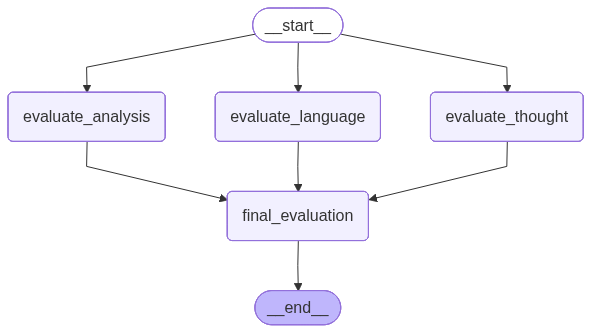

In [36]:
workflow

In [37]:
initial_state = {"essay": sample_essay}

In [38]:
workflow.invoke(initial_state)

{'essay': "India in the Age of AI\nAs the world enters a transformative era defined by artificial intelligence (AI), India stands at a critical juncture — one where it can either emerge as a global leader in AI innovation or risk falling behind in the technology race. The age of AI brings with it immense promise as well as unprecedented challenges, and how India navigates this landscape will shape its socio-economic and geopolitical future.\n\nIndia's strengths in the AI domain are rooted in its vast pool of skilled engineers, a thriving IT industry, and a growing startup ecosystem. With over 5 million STEM graduates annually and a burgeoning base of AI researchers, India possesses the intellectual capital required to build cutting-edge AI systems. Institutions like IITs, IIITs, and IISc have begun fostering AI research, while private players such as TCS, Infosys, and Wipro are integrating AI into their global services. In 2020, the government launched the National AI Strategy (AI for 

In [39]:
# Testing with New samole

sample_essay2 = """India and AI Time

Now world change very fast because new tech call Artificial Intel… something (AI). India also want become big in this AI thing. If work hard, India can go top. But if no careful, India go back.

India have many good. We have smart student, many engine-ear, and good IT peoples. Big company like TCS, Infosys, Wipro already use AI. Government also do program “AI for All”. It want AI in farm, doctor place, school and transport.

In farm, AI help farmer know when to put seed, when rain come, how stop bug. In health, AI help doctor see sick early. In school, AI help student learn good. Government office use AI to find bad people and work fast.

But problem come also. First is many villager no have phone or internet. So AI not help them. Second, many people lose job because AI and machine do work. Poor people get more bad.

One more big problem is privacy. AI need big big data. Who take care? India still make data rule. If no strong rule, AI do bad.

India must all people together – govern, school, company and normal people. We teach AI and make sure AI not bad. Also talk to other country and learn from them.

If India use AI good way, we become strong, help poor and make better life. But if only rich use AI, and poor no get, then big bad thing happen.

So, in short, AI time in India have many hope and many danger. We must go right road. AI must help all people, not only some. Then India grow big and world say "good job India"."""


In [40]:
initial_state = {"essay": sample_essay2}

In [41]:
workflow.invoke(initial_state)

{'essay': 'India and AI Time\n\nNow world change very fast because new tech call Artificial Intel… something (AI). India also want become big in this AI thing. If work hard, India can go top. But if no careful, India go back.\n\nIndia have many good. We have smart student, many engine-ear, and good IT peoples. Big company like TCS, Infosys, Wipro already use AI. Government also do program “AI for All”. It want AI in farm, doctor place, school and transport.\n\nIn farm, AI help farmer know when to put seed, when rain come, how stop bug. In health, AI help doctor see sick early. In school, AI help student learn good. Government office use AI to find bad people and work fast.\n\nBut problem come also. First is many villager no have phone or internet. So AI not help them. Second, many people lose job because AI and machine do work. Poor people get more bad.\n\nOne more big problem is privacy. AI need big big data. Who take care? India still make data rule. If no strong rule, AI do bad.\n\n